# Blood Cells Recognition

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms, models, transforms, datasets
import torch.nn.functional as F

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Get the data

In [4]:
# data augmentation for training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# data pre-processing for validation and test set
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Create training and test sets

In [5]:
training_dataset = datasets.ImageFolder('data/dataset2-master/images/TRAIN/', transform=train_transforms)
test_dataset = datasets.ImageFolder('data/dataset2-master/images/TEST/', transform=test_transforms)

In [6]:
len(training_dataset), len(test_dataset)

(9957, 2487)

Sample a validation set from images in the test set

In [7]:
n_images = len(training_dataset) # number of images in the training set
# create a list of indices of length n_images
indices = list(range(n_images))
np.random.shuffle(indices)

val_pct = 0.2 # percentage for validation set
split = int(np.floor(n_images * val_pct))

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[split:])
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[:split])

Create data loaders

In [8]:
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
classes = training_dataset.classes
classes

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

## Visualize the data

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next() # get the next batch of data
images = images.numpy() # convert from pytorch tensors to numpy arrays

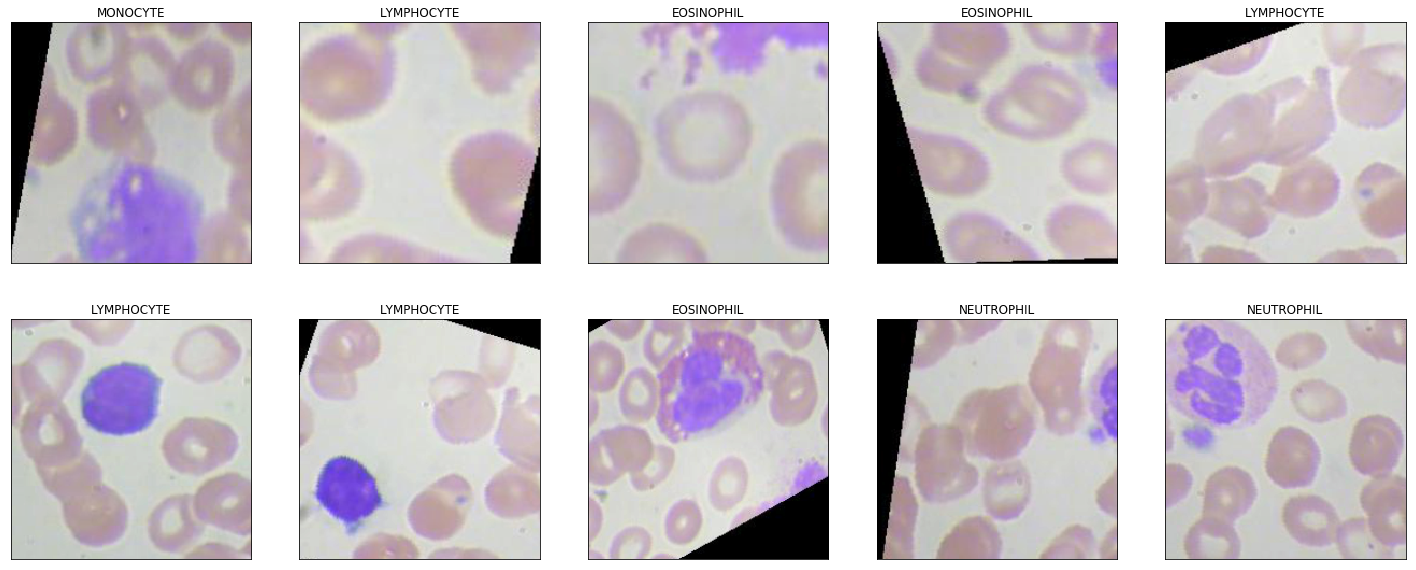

In [11]:
fig = plt.figure(figsize=(25, 10))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    # change the channel order to channel last
    img = np.rollaxis(images[idx], 0, 3)
    # reverse the normalization process
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # show the image
    ax.imshow(img)
    ax.set_title(classes[labels[idx].item()])

## Model

In [12]:
model = models.densenet121(pretrained=True)

#### Freeze the parameters and use the model as a fixed feature extractor

In [13]:
for param in model.parameters():
    param.requires_grad = False

#### Replace the fully connected layer

In [14]:
# number of input features for the fully connected layer
in_features = model.classifier.in_features
in_features

1024

In [15]:
model.classifier = nn.Sequential(nn.Linear(in_features, len(classes)),
                                 nn.LogSoftmax(dim=1))

In [16]:
# put the model on the gpu
model.to(device);

#### Define optimizer and criterion

In [22]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss()

### Train funtion

In [17]:
def train(model, optimizer, criterion, train_loader, val_loader, device, n_epochs):
    # move model to device
    model.to(device);
    
    # list to store training and validation losses
    train_losses = []
    val_losses = []
    best_acc = 0.0
    for epoch in range(n_epochs):
        running_train_loss = 0
        running_val_loss = 0
        train_acc = 0
        val_acc = 0
        
        model.train()
        for images, labels in train_loader:
            # move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # zero out the gradients
            optimizer.zero_grad()
            # forward propagation
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            # backward propagation
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
            # calculate the accuracy
            ps = torch.exp(log_ps) # get the actual probabilities
            top_prob, top_class = ps.topk(1, dim=1) # get the predictions 
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor))
            
        else:
            with torch.no_grad():
                model.eval()
                
                for images, labels in val_loader:
                    # move images and labels to device
                    images, labels = images.to(device), labels.to(device)
                    
                    # forward pass
                    log_ps = model(images)
                    loss = criterion(log_ps, labels)
                    running_val_loss += loss.item()
                    
                    # calculate the accuracy
                    ps = torch.exp(log_ps) # get the actual probabilities
                    top_prob, top_class = ps.topk(1, dim=1) # get the predictions 
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor))
                else:
                    # print metrics
                    print(f'Epoch {epoch + 1}/{n_epochs}\n',
                          f'-'*20,
                          f'\nTraining loss: {running_train_loss/len(train_loader):.3f}   Accuracy: {train_acc/len(train_loader)*100:.3f}',
                          f'\nValidation loss {running_val_loss/len(val_loader):.3f}   Accuracy: {val_acc/len(val_loader)*100:.3f}\n')
                    
                    # check for best model
                    if val_acc/len(val_loader) > best_acc:
                        torch.save(model.state_dict(), 'data/model.pth')
                    # track the losses
                    train_losses.append(running_train_loss/len(train_loader))
                    val_losses.append(running_val_loss/len(val_loader))
    
    # load and return the best model
    model.load_state_dict(torch.load('data/model.pth'))
    return (model, train_losses, val_losses)

Train the model for 5 epochs

In [19]:
model, train_losses, val_losses = train(model, optimizer, criterion, train_loader, val_loader, device, 8)

Epoch 1/8
 -------------------- 
Training loss: 1.231   Accuracy: 44.188 
Validation loss 1.111   Accuracy: 53.690

Epoch 2/8
 -------------------- 
Training loss: 1.072   Accuracy: 54.603 
Validation loss 1.023   Accuracy: 56.703

Epoch 3/8
 -------------------- 
Training loss: 0.999   Accuracy: 58.750 
Validation loss 0.939   Accuracy: 61.454

Epoch 4/8
 -------------------- 
Training loss: 0.951   Accuracy: 61.189 
Validation loss 0.920   Accuracy: 63.456

Epoch 5/8
 -------------------- 
Training loss: 0.933   Accuracy: 61.691 
Validation loss 0.897   Accuracy: 64.886

Epoch 6/8
 -------------------- 
Training loss: 0.916   Accuracy: 62.717 
Validation loss 0.908   Accuracy: 61.544

Epoch 7/8
 -------------------- 
Training loss: 0.905   Accuracy: 62.616 
Validation loss 0.894   Accuracy: 63.679

Epoch 8/8
 -------------------- 
Training loss: 0.892   Accuracy: 63.499 
Validation loss 0.857   Accuracy: 65.744



#### Plot the losses

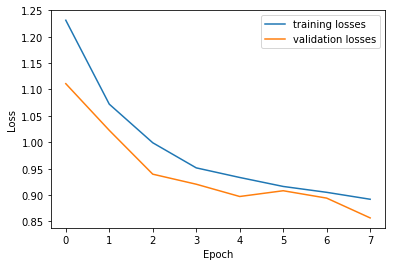

In [20]:
plt.plot(train_losses, label='training losses')
plt.plot(val_losses, label='validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Fine tune the model

In [18]:
model.load_state_dict(torch.load('data/model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

unfreeze the model

In [19]:
for param in model.parameters():
    param.requires_grad = True

initialize a new optimizer

In [23]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model for 10 epochs

In [24]:
model, train_losses, val_losses = train(model, optimizer, criterion, train_loader, val_loader, device, 10)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.43 GiB total capacity; 6.84 GiB already allocated; 6.88 MiB free; 105.55 MiB cached)

## Evaluate the model on the test set

In [ ]:
running_loss = 0
acc = 0
for images, labels in test_loader:
    # move images and labels to device
    images, labels = images.to(device), labels.to(device)

    # forward pass
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    running_loss += loss.item()

    # calculate the accuracy
    ps = torch.exp(log_ps) # get the actual probabilities
    top_prob, top_class = ps.topk(1, dim=1) # get the predictions 
    equals = top_class == labels.view(*top_class.shape)
    acc += torch.mean(equals.type(torch.FloatTensor))
else:
    # print metrics
    print(f'Test loss: {running_loss/len(test_loader):.3f}   Accuracy: {acc/len(test_loader)*100:.3f}',)